## 서론

텍스트 분류는 감정 분석, 스팸 탐지, 해시 태그 예측 등과 같은 다양한 사용 머신 러닝 문제를 해결하는 데 사용할 수 있습니다. 

이 노트북은 SageMaker BlazingText를 사용하여 지도학습의 단일 또는 다중 레이블 텍스트 분류를 수행하는 방법을 보여주고 영화 리뷰 데이터를 사용하여 실제적으로 모델을 구축 및 배포하는 방법을 보여줍니다. 

BlazingText는 멀티 코어 CPU 또는 GPU를 사용하여 몇 분 안에 10억 단어 이상의 단어로 모델을 학습시키는 동시에 최첨단 딥 러닝 텍스트 분류 알고리즘과 동등한 성능을 달성할 수 있습니다. BlazingText는 사용자 지정 CUDA 커널을 사용하여 GPU 가속을 활용하도록 fastText 텍스트 분류기를 확장합니다.

## 셋업

먼저 다음을 지정해 보겠습니다.

- 학습 및 모델 데이터에 사용할 S3 버킷 및 prefix 를 설정합니다. 이 설정은 노트북 인스턴스, 학습 및 호스팅과 동일한 리전 내에 있어야 합니다. 버킷을 지정하지 않으면 SageMaker SDK는 동일한 리전에서 미리 정의된 명명 규칙에 따라 기본 버킷을 생성합니다. 
- 세이지메이커에 데이터에 대한 액세스 권한을 부여하는 데 사용되는 IAM 역할 ARN 을 설정합니다. SageMaker Python SDK에서**get_execution_role** 메서드를 사용하여 가져올 수 있습니다.

In [2]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

# This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf
role = get_execution_role()

bucket = sess.default_bucket()  # Replace with your own bucket name if needed
prefix = "blazingtext/supervised"  # Replace with the prefix under which you want to store the data if needed

### 데이터 준비

웹에서 텍스트 분류 모델을 학습시키려는 데이터세트를 다운로드하겠습니다. BlazingText는 공백으로 구분된 토큰이 있는 단일 전처리된 텍스트 파일을 기대하며 파일의 각 줄에는 단일 문장과 "\__label\__" 접두사가 붙은 레이블이 포함되어야 합니다.

이 노트북에서 사용할 데이터는 네이버 영화 리뷰 데이터입니다. 데이터의 원본은 다음 [Github](https://github.com/e9t/nsmc/) 에서 다운로드 받을 수 있으며, 총 200,000 개 리뷰로 구성된 데이터로 영화 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1, 부정인 경우 0을 표시한 레이블로 구성되어져 있습니다. 



In [3]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f05c26236a0>)

pandas 패키지를 활용하여 데이터를 로드하고 분석을 해봅니다.

In [5]:
import pandas as pd

train_data_raw = pd.read_table('ratings_train.txt')
test_data_raw = pd.read_table('ratings_test.txt')

In [6]:
test_data_raw.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
print('훈련용 리뷰 개수 :',len(train_data_raw)) # 학습용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있습니다. id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시할 예정입니다. 결국 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 모델이 되어야 합니다.

한글 데이터는 띄어쓰기가 되어 있지 않아도 의미를 이해하는데 어려움이 없다는 점을 한번 생각해 보도록 합니다.

In [9]:
print('테스트용 리뷰 개수 :',len(test_data_raw)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


### 데이터 처리

#### 중복 데이터 처리

In [11]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data_raw['document'].nunique(), train_data_raw['label'].nunique()

(146182, 2)

In [12]:
train_data_raw.drop_duplicates(subset=['document'], inplace=True)

<AxesSubplot:>

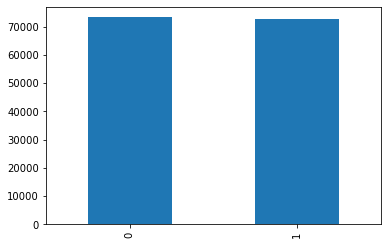

In [14]:
train_data_raw['label'].value_counts().plot(kind = 'bar')

0과 1의 데이터가 balanced 되어 있는것을 확인할 수 있습니다.

In [15]:
train_data_raw.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,73342
1,1,72841


레이블이 0이나 1인 데이터 중, Null 값이 있는지 확인합니다. 다음 코드 실행 후 True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미입니다.

In [16]:
train_data_raw.isnull().values.any()

True

In [17]:
train_data_raw.isnull().sum()

id          0
document    1
label       0
dtype: int64

리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다는 결과값이 나오고 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력해 볼 수 있습니다.

In [18]:
train_data_raw.loc[train_data_raw.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [19]:
train_data_raw = train_data_raw.dropna(how = 'any') # Null 값이 존재하는 행 제거

In [20]:
train_data_raw.isnull().values.any()

False

#### 데이터 전처리

train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. train_data 로부터 한글만 남기고 제거하기 위해서 Regular Expression(정규 표현식) 을 사용해보겠습니다.

영어를 예로 들면 영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]입니다. 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 이를 응용하면 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있습니다. 예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같습니다.

In [22]:
import re
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 됩니다. 우선 자음과 모음에 대한 범위를 지정해보겠습니다. 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ 힣 와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 다음 [유니코드 문서](https://www.unicode.org/charts/PDF/U3130.pdf) 를 참고하시기 바랍니다.

* ㄱ ~ ㅎ: 3131 ~ 314E
* ㅏ ~ ㅣ: 314F ~ 3163

해당 범위 내에 포함된 음절들은 다음 [유니코드 문서](https://www.unicode.org/charts/PDF/UAC00.pdf) 에서 확인할 수 있습니다.

위 범위 지정을 모두 반영하여 train_data 에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해 봅니다.

In [23]:
# 한글과 공백을 제외하고 모두 제거
train_data_raw['document'] = train_data_raw['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [24]:
train_data_raw.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


다음은 영화 리뷰 중 특수문자나 영어, 숫자만으로 이루어져 있는 리뷰들이 있을 수 있으므로 이런 데이터들은 위 과정에서 Null 내지는 white space 로 변경되었을 것입니다. train_data 에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인해보겠습니다.

In [25]:
train_data_raw['document'] = train_data_raw['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경

In [27]:
import numpy as np

In [28]:
train_data_raw['document'].replace('', np.nan, inplace=True)

In [29]:
train_data_raw.isnull().sum()

id            0
document    789
label         0
dtype: int64

In [30]:
train_data_raw = train_data_raw.dropna(how = 'any')

In [60]:
train_data_raw.to_csv('ratings_train_stage.txt', index=False, sep='\t')

training 세트에 대한 전처리가 완료되었으므로 이를 test/validation 세트에도 적용시키도록 합니다.

In [61]:
test_data_raw.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data_raw['document'] = test_data_raw['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data_raw['document'] = test_data_raw['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data_raw['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data_raw = test_data_raw.dropna(how='any') # Null 값 제거

In [62]:
'전처리 후 테스트용 샘플의 개수 : ' + str(len(test_data_raw))

'전처리 후 테스트용 샘플의 개수 : 48389'

In [63]:
test_data_raw.to_csv('ratings_test_stage.txt', index=False, sep='\t')

In [64]:
!head ratings_train_stage.txt -n 5

id	document	label
9976970	아 더빙 진짜 짜증나네요 목소리	0
3819312	흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 솔직히 재미는 없다평점 조정	0


BlazingText 알고리즘으로 분류 문제를 학습하기 위해서는 말뭉치 데이터의 각 문장의 클래스 레이블 앞에 \__label__을 접두사로 붙여야 합니다. 변환 예시는 아래를 참조해 주세요.

\__label__0 아 더빙.. 진짜 짜증나네요 목소리

\__label__1 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나

In [65]:
def preprocess_text(corpus_path, output_path):
    with open(corpus_path, 'r', encoding='utf-8') as f, \
        open(output_path, 'w', encoding='utf-8') as fw:
        next(f)
        for line in f:
            # Remove tab
            _, sentence, label = line.strip().split('\t') 
            if not sentence: continue
            fw.writelines('__label__' + label + ' '+ sentence + '\n')    

In [66]:
corpus_path = 'ratings_train_stage.txt'
output_path = 'ratings_train_preprocessd'
preprocess_text(corpus_path, output_path)

In [67]:
!head ratings_train_preprocessd -n 5

__label__0 아 더빙 진짜 짜증나네요 목소리
__label__1 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
__label__0 너무재밓었다그래서보는것을추천한다
__label__0 교도소 이야기구먼 솔직히 재미는 없다평점 조정
__label__1 사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다


In [68]:
corpus_path = 'ratings_test_stage.txt'
output_path = 'ratings_test_preprocessd'
preprocess_text(corpus_path, output_path)

In [69]:
!head ratings_test_preprocessd -n 5

__label__1 굳 ㅋ
__label__0 뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
__label__0 지루하지는 않은데 완전 막장임 돈주고 보기에는
__label__0 만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠
__label__1 음악이 주가 된 최고의 음악영화


### S3 경로 설정

In [70]:
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='ratings_train_preprocessd', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='ratings_test_preprocessd', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

모델 아티팩트(Model Artifact)가 저장될 S3의 경로를 설정합니다.

In [71]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [72]:
s3_train_data

's3://sagemaker-ap-northeast-2-806174985048/blazingtext/supervised/train'

In [73]:
s3_validation_data

's3://sagemaker-ap-northeast-2-806174985048/blazingtext/supervised/validation'

In [74]:
s3_output_location

's3://sagemaker-ap-northeast-2-806174985048/blazingtext/supervised/output'

### 모델 Training

In [80]:
region_name = boto3.Session().region_name
# container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
container = sagemaker.image_uris.retrieve(region=region_name, framework = "blazingtext")
print('SageMaker BlazingText 컨테이너 위치: {} ({})'.format(container, region_name))

SageMaker BlazingText 컨테이너 위치: 306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/blazingtext:1 (ap-northeast-2)


SageMaker BlazingText는 Word2Vec의 구현과 유사하게 네거티브 샘플링(Negative Sampling)을 사용하여 CPU 및 GPU(들)에서 CBOW(Continuous Bag-of-Words) 및 스킵 그램(Skip-gram) 아키텍처를 효율적으로 구현합니다. GPU 구현은 고도로 최적화된 CUDA 커널을 사용합니다. 자세한 내용은 [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354)를 참조하세요. 

또한, BlazingText는 CBOW 및 스킵 그램 모드로 서브 워드(subwords) 임베딩 학습을 지원합니다. 이를 통해 BlazingText는 out-of-vocabulary(OOV)를 생성할 수 있습니다.
서브 워드 임베딩 학습은 [notebook (text8 데이터셋 서브 워드 임베딩)](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb)을 참조하세요.

스킵 그램 및 CBOW 외에도 SageMaker BlazingText는 효율적인 미니 배치 및 행렬 연산을 수행하는 "배치 스킵 그램(Batch Skipgram)" 모드도 지원합니다. ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)) 이 모드는 여러 CPU 노드에 걸쳐 분산된 Word2Vec의 학습을 가능하게 하여 보다 빠른 학습이 가능합니다. 자세한 내용은 [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf)를 참조하세요.

BlazingText는 텍스트 분류를 위한 교사 학습(supervised learning)도 지원하며, 사용자 지정 CUDA 커널을 사용하여 GPU 가속을 활용하도록 FastText 텍스트 분류기를 확장합니다. 이 모델은 최신 딥러닝 텍스트 분류 알고리즘과 동등한 성능을 달성하면서 멀티 코어 CPU 또는 GPU를 사용하여 몇 분 안에 10억 단어 이상을 학습할 수 있습니다. 자세한 내용은 [알고리즘 설명서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html)를 참조하세요.


아래 표는 BlazingText에서 지원하는 모드입니다.

|          Modes         	| cbow (서브워드 학습 지원) 	| skipgram (서브워드 학습 지원) | batch_skipgram | supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:| :--------------:|
|   단일 CPU 인스턴스  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   단일 GPU 인스턴스  	|   ✔  	|     ✔    	|              X  	|  ✔ (1 GPU 인스턴스만 지원)  |
| 다중 CPU 인스턴스 	|   X 	|     X     	|        ✔       	 |  X    |

In [81]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size=30,
                                         train_max_run=360000,
                                         input_mode='File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


BlazingText 하이퍼파라메터의 자세한 설정 방법은 [이 문서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html)를 참조해 주세요.

In [82]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=30,
                            min_count=2,
                            learning_rate=0.005,
                            vector_dim=100,
                            early_stopping=True,
                            patience=4,  # Number of epochs to wait before early stopping if no progress on the validation set is observed
                            buckets=2000000, # Number of hash buckets to use for word n-grams
                            min_epochs=5,
                            word_ngrams=2)

학습을 위한 `sagemaker.session.s3_input` 객체를 생성하여 데이터 채널을 알고리즘과 연결합니다.

In [83]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


지금까지 `Estimator` 객체에 대한 하이퍼파라미터를 설정했으며 데이터 채널을 알고리즘과 연결했습니다. 남은 것은 `fit` 메소드로 학습하는 것뿐입니다.<br>
학습에는 몇 가지 단계가 포함됩니다. 먼저 `Estimator` 클래스를 작성하는 동안 요청한 인스턴스가 프로비저닝되고 적절한 라이브러리로 설정됩니다. 그 다음 채널의 데이터가 학습 인스턴스로 다로드되며 이후 학습 작업이 시작됩니다. 데이터 크기에 따라 프로비저닝 및 데이터 다운로드에 시간이 다소 걸리며, 이에 따라 학습 작업에 따른 로그를 확인하는 데 몇 분이 걸립니다.

로그는 `min_epochs`(이 파라메터는 학습에 최소로 필요한 epoch 횟수입니다) 이후 모든 epoch에 대한 검증 데이터의 정확도(accuracy)를 출력합니다.

학습이 완료되면 "작업 완료(Job compelete)" 메시지가 출력됩니다. 학습된 모델은 `Estimator`에서 `output_path`로 설정된 S3 버킷에서 찾을 수 있습니다.

In [ ]:
bt_model.fit(inputs=data_channels, logs=True)

2022-04-05 14:34:49 Starting - Starting the training job...
2022-04-05 14:35:17 Starting - Preparing the instances for trainingProfilerReport-1649169289: InProgress
.........
2022-04-05 14:36:41 Downloading - Downloading input data
2022-04-05 14:36:41 Training - Downloading the training image..Arguments: train
[04/05/2022 14:36:59 WARNING 140654538295104] Loggers have already been setup.
[04/05/2022 14:36:59 WARNING 140654538295104] Loggers have already been setup.
[04/05/2022 14:36:59 INFO 140654538295104] nvidia-smi took: 0.025286197662353516 secs to identify 0 gpus
[04/05/2022 14:36:59 INFO 140654538295104] Running single machine CPU BlazingText training using supervised mode.
Number of CPU sockets found in instance is  1
[04/05/2022 14:36:59 INFO 140654538295104] Processing /opt/ml/input/data/train/ratings_train_preprocessd . File size: 13.551183700561523 MB
[04/05/2022 14:36:59 INFO 140654538295104] Processing /opt/ml/input/data/validation/ratings_test_preprocessd . File size: 4.5

#### Tip
데이터셋이 잘 정제되어 있어 전처리를 거의 수행하지 않았음에도 검증셋에서 비교적 높은 정확도(accuracy)를 보입니다.
이를 baseline으로 잡고 불용어(stopword) 제거, 형태소 분석 등의 전처리와 하이퍼파라메터 튜닝을 통해 
좀 더 높은 정확도를 달성할 수 있습니다. 특히, 한국어 데이터의 다운스트림 작업들은 하이퍼파라메터 튜닝보다는 전처리가 훨씬 중요하니 이 점을 유의해 주세요.

## Hosting / Inference
학습을 완료하면 모델을 Amazon SageMaker 실시간 호스팅 엔드포인트(real-time hosted endpoint)로 배포할 수 있고, 이를 통해 모델로부터 추론(inference)을 수행합니다. (추론은 예측; prediction 이라고도 합니다.) 실시간 추론 수행 시 엔드포인트는 계속 가동되어야 하므로, 추론을 위해 저렴한 인스턴스를 선택하시는 것을 권장합니다.

이 과정은 약 10분 정도 소요됩니다.

In [85]:
text_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

------!

#### Use JSON format for inference

BlazingText는 추론을 위한 컨텐츠 유형(content-type)으로 `application/json` 을 지원합니다. 엔드포인트로 전달할 입력 문장은 "**instances**" 키가 반드시 포함되어야 합니다.

In [89]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [101]:
sentences = ["재미있게 봤습니다. 제 점수는요 100점 만점에 80점 드리겠습니다.",
            "스토리가 너무 단방향이라 재미가 없고 성우 더빙도 그닥이네요..."]

tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]
payload = {"instances" : tokenized_sentences, "configuration": {"k": 2}}



In [102]:
payload

{'instances': ['재미있게 봤습니다 . 제 점수는요 100점 만점에 80점 드리겠습니다 .',
  '스토리가 너무 단방향이라 재미가 없고 성우 더빙도 그닥이네요 ...'],
 'configuration': {'k': 2}}

In [104]:
response = text_classifier.predict(json.dumps(payload),
    initial_args={"ContentType": "application/json", "Accept": "application/json"},)

In [105]:
predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "label": [
      "__label__1",
      "__label__0"
    ],
    "prob": [
      0.9349859952926636,
      0.06503401696681976
    ]
  },
  {
    "label": [
      "__label__0",
      "__label__1"
    ],
    "prob": [
      0.9972277879714966,
      0.0027921993751078844
    ]
  }
]


#### (Optional) 토큰화

토큰화를 진행하고 토큰화 과정에서 불용어를 제거해 봅니다. 불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다. 아래의 불용어는 한 예제입니다.

In [37]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 19.3 MB/s            
     |████████████████████████████████| 448 kB 109.0 MB/s            


In [38]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [39]:
from konlpy.tag import Okt

okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

Okt는 위와 같이 KoNLPy 에서 제공하는 형태소 분석기입니다. 한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용합니다. stem = True를 사용하면 일정 수준의 정규화를 수행해주는데, 예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환된 것을 알 수 있습니다. 자세한 사용법은 [KoNLPy](https://konlpy.org/en/latest/) 홈페이지에서 확인 가능합니다.